In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

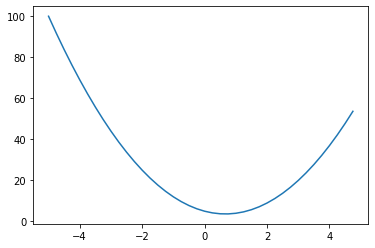

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
# The definition of derivative

h = 0.0000000001
x = 3.0

(f(x + h) - f(x)) / h

14.000001158365194

In [6]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c

d

4.0

In [7]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

# The reason that the slope is one is because:
# ((a*b + c+h) - (a*b + c)) / h
# => h / h = 1

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [53]:
class Value:
    def __init__(self, data, children=(), op='', label=''):
        self.data = data
        self.prev = set(children)
        self.op = op
        self.label = label
        self.grad = 0.0
        self.backward = lambda: None

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, children=(self, other), op="+")

        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out.backward = _backward

        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, children=(self, other), op="*")

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out.backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad = 1 - t**2 * out.grad
        out.backward = _backward

        return out

In [9]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)

print(a, b, c)

Value(data=2.0) Value(data=-3.0) Value(data=10.0)


In [10]:
z = a + b
z

Value(data=-1.0)

In [11]:
z.prev

{Value(data=-3.0), Value(data=2.0)}

In [12]:
z.op

'+'

In [13]:
y = a*b + c
y

Value(data=4.0)

In [14]:
y.prev

{Value(data=-6.0), Value(data=10.0)}

In [15]:
y.op

'+'

In [16]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [17]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v.prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n.op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n.op, label = n.op)
      # and connect this node to it
      dot.edge(uid + n.op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2.op)

  return dot

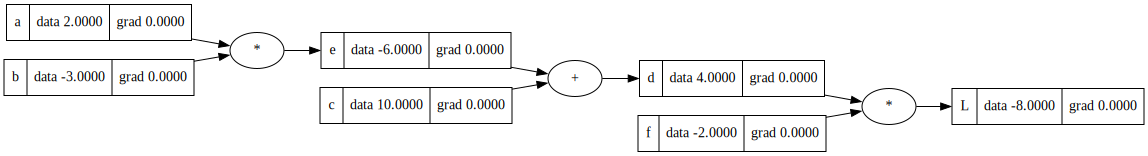

In [18]:
draw_dot(L)

In [19]:
# Use equations to solve gradients manually

# e = a*b; e.label = 'e'
# d = e + c; d.label = 'd'
# L = d * f; L.label = 'L'

In [20]:
L.grad = 1.0

In [21]:
f.grad = 4.0
d.grad = -2.0

In [22]:
# dL/de = dd/de * dL/dd
e.grad = -2.0
c.grad = -2.0

In [23]:
# dL/db = de/db * dd/de * dL/dd
# a * -2
b.grad = -4.0
a.grad = 6.0

In [24]:
# # Let's change values by their gradients (simulate gradient descent)
# lr = 0.01
#
# a.data += lr * a.grad
# b.data += lr * b.grad
# c.data += lr * c.grad
# f.data += lr * f.grad
#
# e = a * b
# d = e + c
# L = d * f
#
# print(L.data)

### Neurons Example

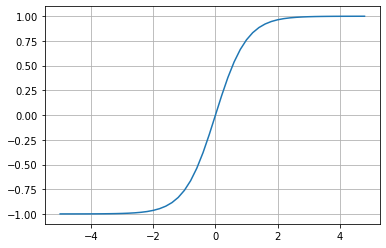

In [25]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid()

In [57]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1
x1w1.label = 'x1*w1'

x2w2 = x2*w2
x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b
n.label = 'n'

o = n.tanh()
o.label = 'output'

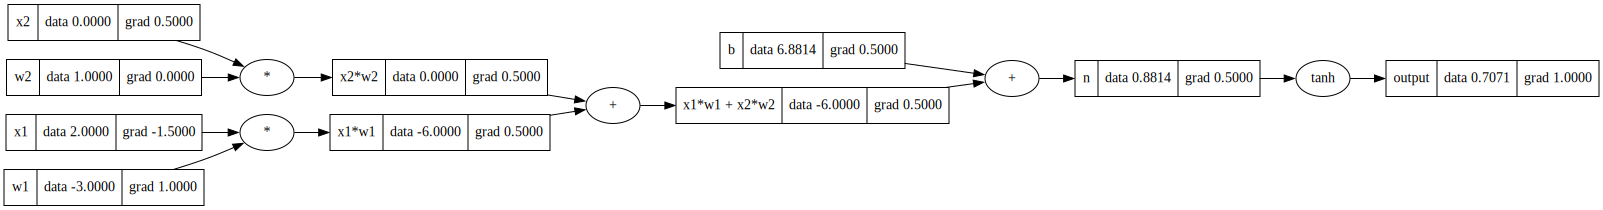

In [64]:
draw_dot(o)

In [28]:
o.grad = 1.0

In [29]:
# o = tanh(n)
# do/dn = 1 - tanh(n)**2 = 1 - o**2

In [30]:
n.grad = 1 - o.data**2

In [31]:
b.grad = 0.5
x1w1x2w2.grad = 0.5

In [32]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [33]:
# do/dw1 = do/dn * dn/dx1w1x2w2 * dx1w1x2w2/dx1w1 * dx1w1/dw1
w1.grad = x1.data * x1w1.grad
x1.grad = w1.data * x1w1.grad

w2.grad = x2.data * x2w2.grad
x2.grad = w2.data * x2w2.grad

#### Call our backward() funtion

In [58]:
o.grad = 1.0

In [59]:
o.backward()

In [60]:
n.backward()

In [61]:
x1w1x2w2.backward()

In [62]:
x1w1.backward()

In [63]:
x2w2.backward()